
# Technical Test: Python and SQLAlchemy Proficiency

## Objective

This test is designed to assess your proficiency in Python programming and your understanding of Object-Relational Mapping (ORM) using SQLAlchemy. You will interact with a small database application in a Jupyter Notebook environment, showcasing your ability to manage and manipulate data effectively.

## Test Environment

The test will be conducted in a Jupyter Notebook hosted on GitHub. All necessary libraries, including SQLAlchemy, are pre-installed, and the environment is set up for you. You will work on a fork of the provided repository.

## Test Overview

You will complete a series of tasks that involve interacting with a small database application using Python and SQLAlchemy. The test will evaluate your ability to:

1. **Implement ORM Models**: Create Python classes that map to database tables using SQLAlchemy ORM, including fields, relationships, and constraints.

2. **Perform CRUD Operations**: Write Python code to perform Create, Read, Update, and Delete operations on the database using SQLAlchemy.

3. **Query Optimization**: Demonstrate your ability to write efficient queries, utilizing SQLAlchemy features to optimize database access.

4. **Handle Transactions**: Implement transaction management to ensure data integrity during complex operations.

5. **Documentation and Code Quality**: Provide clear documentation and adhere to best practices in code structure and style.

## Instructions

1. **Fork the Repository**: Start by forking the provided GitHub repository to your own account.

2. **Access the Jupyter Notebook**: Open the Jupyter Notebook in your forked repository to begin the test.

3. **Complete the Tasks**: Follow the instructions in the notebook to complete each task. Ensure your code is functional and meets the specified requirements.

4. **Use SQLAlchemy Documentation**: Refer to the [SQLAlchemy documentation](https://docs.sqlalchemy.org) as needed to assist with your implementation.

5. **Commit Your Changes**: Once you have completed the tasks, commit your changes to your forked repository.

6. **Submit Your Test**: Notify us by providing a link to your forked repository with your completed test.

## Evaluation Criteria

-  **Correctness**: The solution should meet all specified requirements and perform all operations correctly.
-  **Code Quality**: Code should be clean, well-organized, and follow Python best practices.
-  **Efficiency**: Solutions should be optimized for performance, especially in the context of database operations.
-  **Problem Solving**: Demonstrated ability to effectively solve problems and make sound design decisions.
-  **Documentation**: Clear and concise documentation that helps reviewers understand your approach and implementation.

We look forward to reviewing your work and assessing your potential to contribute to our development team.

In [1]:
import sqlalchemy as sa

import models as m

# First, let's connect to the database
engine = sa.create_engine("sqlite:///quiz.db")
SessionMaker = sa.orm.sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionMaker()

In [2]:
# example query sites
sites_query = sa.select(m.Site).limit(10)
sites = list(session.execute(sites_query).scalars())
print(sites)

[<Site n°1 - GigaWatt Llama Ranch>, <Site n°2 - Sunny Side of the Moon>, <Site n°3 - River Dance Powerhouse>, <Site n°4 - Turbine Nation Offshore>, <Site n°5 - Sunshine & Chill Canopy>, <Site n°6 - Watts in the Attic>, <Site n°7 - Flow like a River>, <Site n°8 - Juicy Biomass Co-op>, <Site n°9 - Offshore Avengers>, <Site n°10 - Trash into Cash>]


### Question 1 :

Based on all the sites in the db, make a summary of the modelled data. Please choose the best metrics to display and best grouping to do. (count, sum on some attribute grouped by another attribute etc...)

In [3]:
# total site count
site_count_query = sa.select(sa.func.count(m.Site.id))
total_sites = session.execute(site_count_query).scalar()

print("Total number of sites:", total_sites)
# total and average installed capacity
print("\n######## overall capacity info  ########\n")
capacity_total_avg_query = sa.select(
    sa.func.sum(m.Site.capacity).label("cap_total"),
    sa.func.avg(m.Site.capacity).label("cap_avg"),
)
capacity_result = session.execute(capacity_total_avg_query).first()
print("Total sum of capacity : ", capacity_result.cap_total, " Kw ")
print("Average of capacity : ", capacity_result.cap_avg, " Kw")
# count and capacity grouped by yechno

techno_query = sa.select(
    m.Site.techno,
    sa.func.count(m.Site.id).label("site_count"),
    sa.func.sum(m.Site.capacity).label("capacity_sum"),
    sa.func.avg(m.Site.capacity).label("capacity_avg"),
).group_by(m.Site.techno)
print("\n######## capacity info grouped by techno ########\n")

techno_result = session.execute(techno_query)
for tech in techno_result:
    print(
        f"Techno: {tech.techno}, Count: {tech.site_count}, Total Capacity: {tech.capacity_sum} kW, Average Capacity: {tech.capacity_avg} kW"
    )

# contract associated with cities
print("\n######## cntract count for each city ########\n")
contract_query = (
    sa.select(m.Site.name, sa.func.count(m.Contract.id).label("contract_count"))
    .join(m.Site.contracts)
    .group_by(m.Site.id)
)

contracts_res = session.execute(contract_query).all()
for r in contracts_res:
    print(f" site: {r.name}, contract count: {r.contract_count}")

Total number of sites: 99

######## overall capacity info  ########

Total sum of capacity :  2844419.0  Kw 
Average of capacity :  28731.50505050505  Kw

######## capacity info grouped by techno ########

Techno: cogeneration_biomass, Count: 8, Total Capacity: 208500.0 kW, Average Capacity: 26062.5 kW
Techno: cogeneration_other, Count: 3, Total Capacity: 76000.0 kW, Average Capacity: 25333.333333333332 kW
Techno: cogeneration_waste, Count: 6, Total Capacity: 70000.0 kW, Average Capacity: 11666.666666666666 kW
Techno: hydro_turbine_pumped_storage, Count: 8, Total Capacity: 219000.0 kW, Average Capacity: 27375.0 kW
Techno: hydro_turbine_reservoir, Count: 8, Total Capacity: 185000.0 kW, Average Capacity: 23125.0 kW
Techno: hydro_turbine_run_of_river, Count: 7, Total Capacity: 171000.0 kW, Average Capacity: 24428.571428571428 kW
Techno: solar_field_canopy, Count: 10, Total Capacity: 66100.0 kW, Average Capacity: 6610.0 kW
Techno: solar_field_ground_mounted, Count: 11, Total Capacity: 2555

### Question 2: 
Could you plot a map and tell in which coutries are all the sites ? 
Is there any pb with a site ?

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from pyproj import Transformer

sites = list(session.execute(sa.select(m.Site)).scalars())
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
geolocator = Nominatim(user_agent="site_locator")


def get_country(latitude, longitude):
    longitude, latitude = transformer.transform(longitude, latitude)
    try:
        location = geolocator.reverse((latitude, longitude), language="en")
        print(f"converted latitide {location[0]} converted longitude {location[1]}")
        if location and "country" in location.raw["address"]:
            print(
                f"Geocoding success with latitude : {latitude}, longitude :{longitude}"
            )
            return location.raw["address"]["country"]
    except Exception as e:
        print(f"Geocoding error with latitude : {latitude}, longitude :{longitude} !")
    return None


site_coords = [(site.latitude, site.longitude) for site in sites]
countries = [get_country(lat, lon) for lat, lon in site_coords]

Geocoding error with latitude : 89.87573986002526, longitude :-4.493256270178911 !
Geocoding error with latitude : 89.8855436759464, longitude :25.50238039870319 !
Geocoding error with latitude : 89.90678467375533, longitude :-3.3174244453363455 !
Geocoding error with latitude : 89.86875640447036, longitude :8.650883983905086 !
Geocoding error with latitude : 89.93726132985923, longitude :-12.604989386861142 !
Geocoding error with latitude : 89.90329073161745, longitude :-4.380805162912829 !
Geocoding error with latitude : 89.89440368989271, longitude :0.23596047567967468 !
Geocoding error with latitude : 89.92307708817413, longitude :-3.7916181343645174 !
Geocoding error with latitude : 89.90147523609724, longitude :38.74638636292275 !
Geocoding error with latitude : 89.90335230254294, longitude :40.991554735675514 !
Geocoding error with latitude : 89.89929145841501, longitude :-6.497792927774575 !
Geocoding error with latitude : 89.88993670986598, longitude :15.25322284444549 !
Geoco

In [ ]:
# as what i see that with latitudes 89. values extremely close to the poles may not
# fall within the bounds of any recognized country,  this is the reason of None in countries array
# even with the last record where latitude is 39., so there is latitude and longitude uncorrectly assigned in the data. 
print(countries)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'Greece', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'Turkmenistan', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'Algeria', None, None, None, None, None, None, None, None, None]


### Question 3:
- Get me sites that have timeseries configured.
- which site has contract defined ?

In [6]:
sites_with_timeseries_query = sa.select(m.Site).join(m.TSRecords).distinct()
sites_with_timeseries = session.scalars(sites_with_timeseries_query).all()

print("Sites with timeseries configured:")
for site in sites_with_timeseries:
    print(site)


sites_with_contracts_query = sa.select(m.Site).join(m.Contract).distinct()
sites_with_contracts = session.scalars(sites_with_contracts_query).all()

print("\nSites with contracts defined:")
for site in sites_with_contracts:
    print(site)

Sites with timeseries configured:
Barrage Mont Sunny
Energy for the Brave
Mont Venteux
Reservoir Dogs Energy
Village Solaire

Sites with contracts defined:
GigaWatt Llama Ranch
Sunny Side of the Moon
River Dance Powerhouse
Turbine Nation Offshore
Sunshine & Chill Canopy
Watts in the Attic
Flow like a River
Juicy Biomass Co-op
Offshore Avengers
Trash into Cash
Pumped Up Hydro
Sunset Boulevard Energy
Windy Wizards
Energy for the Brave
Reservoir Dogs Energy
Village Solaire
Barrage Mont Sunny
Mont Venteux


### Question 4:
Focus on site with contracts

If you were to analyse the contracts, choose one that you would focus to leverage the most k€, why ?

In [7]:
from sqlalchemy import Integer, cast, func

contracts_query = (
    session.query(
        m.Contract,
        (cast((m.Contract.end_date - m.Contract.start_date), Integer)).label(
            "contract_duration_days"
        ),
        func.sum(m.Invoice.amount).label("total_invoice_amount"),
    )
    .join(m.Contract.invoices)
    .group_by(m.Contract.id)
    .order_by(func.sum(m.Invoice.amount).desc())
    .limit(1)
)

highest_value_contract = contracts_query.first()
print(highest_value_contract)

(<Contract n°14 - PO-1619-14>, 20, 39772225584.0)


### Question 5:
Timeseries : 
- Could you plot monthly production & financial report for the sites that have timeseries ?

/tmp/ipykernel_2149/3373968201.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_report = df.resample("M").agg({"production": "sum", "cashflow": "sum"})


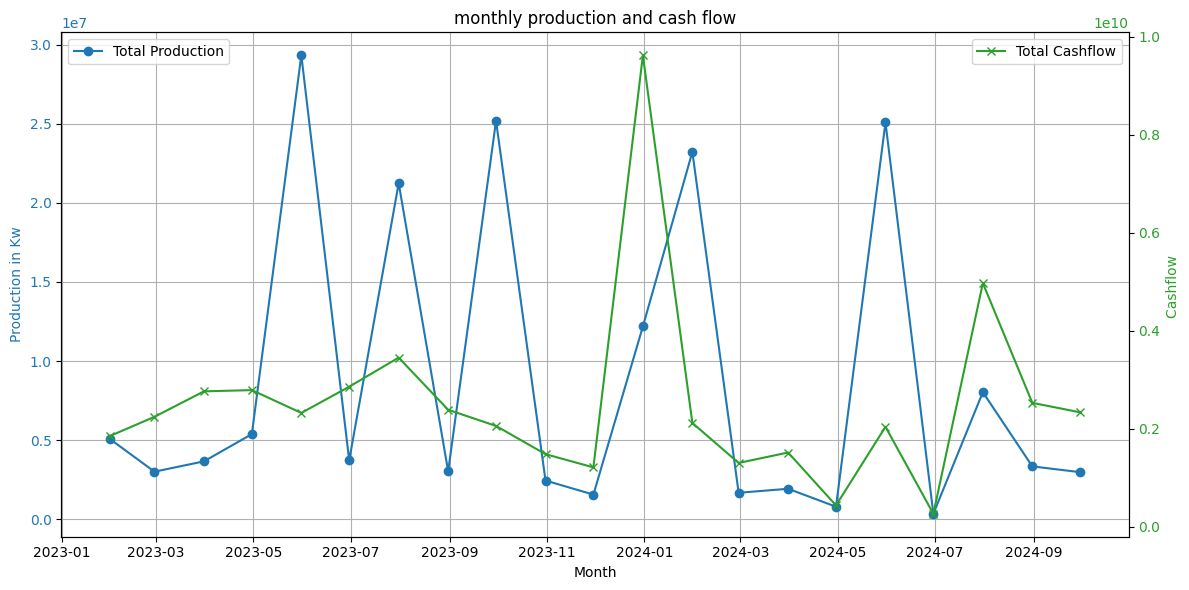

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# extract timeseries data and saved in data list

ts_records_query = session.query(m.TSRecords).all()
data = []
for record in ts_records_query:
    data.append(
        {
            "site_id": record.site_id,
            "timestamp": record.timestamp,
            "production": record.production,
            "cashflow": record.cashflow,
        }
    )

# convert it to dataframe
df = pd.DataFrame(data)

# convert the timestamp to datetime in days
df["timestamp"] = pd.to_datetime(df["timestamp"])

# set the timestamp to index
df.set_index("timestamp", inplace=True)

# Resample the data to monthly frequency and aggregate
monthly_report = df.resample("M").agg({"production": "sum", "cashflow": "sum"})


fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.set_title("monthly production and cash flow")
ax1.set_xlabel("Month")
ax1.set_ylabel("Production in Kw", color="tab:blue")
ax1.plot(
    monthly_report.index,
    monthly_report["production"],
    color="tab:blue",
    label="Total Production",
    marker="o",
)
ax1.tick_params(axis="y", labelcolor="tab:blue")

# create other y-axis for cashflow
ax2 = ax1.twinx()
ax2.set_ylabel("Cashflow ", color="tab:green")
ax2.plot(
    monthly_report.index,
    monthly_report["cashflow"],
    color="tab:green",
    label="Total Cashflow",
    marker="x",
)
ax2.tick_params(axis="y", labelcolor="tab:green")

ax1.grid()
fig.tight_layout()  # adjust the layout to avoid clipping the y axis
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()